In [1]:
import re
import glob
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
from graphviz import Digraph
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from heapq import nlargest
import os
os.environ["PATH"] += os.pathsep + 'C:\\graphviz\\bin'

In [2]:
def get_colored_graph(file):
    g = Digraph('G')
    g.attr(size='20')
    with open(file, 'r', encoding="utf8") as f:
        data = json.load(f)
    g.attr('node')
    for key in data:
        score = data[key]['sentiment']
        if(score <= -0.8):
            g.node(key, color='#67001F', style="filled")
        elif(score > -0.8 and score <= -0.6):
            g.node(key, color='#B2172B', style="filled")
        elif(score > -0.6 and score <= -0.4):
            g.node(key, color='#D6604D', style="filled")
        elif(score > -0.4 and score <= -0.2):
            g.node(key, color='#F4A582', style="filled")
        elif(score > -0.2 and score < 0):
            g.node(key, color='#FDDBC7', style="filled")
        elif(score == 0.0):
            g.node(key, color='#F8F8F8', style="filled")
        elif(score > 0.0 and score <= 0.2):
            g.node(key, color='#D1E5F0', style="filled")
        elif(score > 0.2 and score <= 0.4):
            g.node(key, color='#92C5DF', style="filled")
        elif(score > 0.4 and score <= 0.6):
            g.node(key, color='#4393C3', style="filled")
        elif(score > 0.6 and score <= 0.8):
            g.node(key, color='#2166AC', style="filled")
        elif(score > 0.8):
            g.node(key, color='#053061', style="filled")
    for key in data:
        if(key is not None):
            if(data[key]["replie_to"] is not None):
                g.edge(data[key]["replie_to"], key)
    g.view()

In [3]:
def word_cloud(lista, name_file):
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    for each in lista:
        aux = list()
        for item in graphs[each]:
            val = str(graphs[each].nodes[item]['text'])

            # typecaste each val to string 
            val = str(val) 

            val = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', val, flags=re.MULTILINE)


            # split the value 
            tokens = val.split() 

            # Converts each token into lowercase 
            for i in range(len(tokens)): 
                tokens[i] = tokens[i].lower() 

            for words in tokens: 
                comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud)
    _= plt.axis("off") 
    _= plt.tight_layout(pad = 0) 
    _= plt.savefig(name_file, quality = 95, orientation='portrait')

In [4]:
def get_dist_sentiment(lista):
    dist_sentiment = dict()
    for each in lista:
        aux = list()
        for item in graphs[each]:
            aux.append(graphs[each].nodes[item]['sentiment'])
        dist_sentiment[each] = np.array(aux)
    positives = dict()
    negatives = dict()
    for i in dist_sentiment:
        k = int(len(dist_sentiment[i])*0.5)
        if(k != 0):
            number = max(nlargest(k, dist_sentiment[i]))
        else:
            number = dist_sentiment[i][0]
        if(number >= 0):
            positives[i] = dist_sentiment[i]
        else:
            negatives[i] = dist_sentiment[i]
    return dist_sentiment, positives, negatives

In [75]:
def gen_boxplot(distribution_vec, name_file):
    # Create a figure instance
    fig = plt.figure(1, figsize=(20, 10))

    # Create an axes instance
    ax = fig.add_subplot(111)
    plt.rc('ytick', labelsize=15) 
    plt.rc('xtick', labelsize=15) 
    
    #Limiar do tweet original
    X = np.linspace(0, len(distribution_vec), len(distribution_vec))
    Y = 0*X + graphs[original].nodes[item]['sentiment']
    plt.plot(X, Y, sns.xkcd_rgb["pale red"], lw=3)
    
    #Eixo 0
    X0 = np.linspace(0, len(distribution_vec), len(distribution_vec))
    Y0 = 0*X
    plt.plot(X0, Y0, sns.xkcd_rgb["blue"], lw=3)
    
    # Create the boxplot
    bp = ax.boxplot(distribution_vec)

    # Save the figure
    _= plt.savefig(name_file, quality = 95, orientation='portrait')

In [58]:
def gen_violin(distribution_vec, name_file, original=None):
    sns.set(rc={'figure.figsize':(80,40)})
    sns.set(font_scale=2.5)
    ax = sns.violinplot(data=list(distribution_vec), inner="stick")
    if original != " ":
        item = original.split("_")
        item = item[1].split(".")
        item = item[0]
        X = np.linspace(0, len(distribution_vec), len(distribution_vec))
        Y = 0*X + graphs[original].nodes[item]['sentiment']
        plt.plot(X, Y, sns.xkcd_rgb["pale red"], lw=3)
        X0 = np.linspace(0, len(distribution_vec), len(distribution_vec))
        Y0 = 0*X
        plt.plot(X0, Y0, sns.xkcd_rgb["blue"], lw=3)
    _= plt.savefig(name_file, quality = 95, orientation='portrait')

In [45]:
files = glob.glob("dados//believes//*.json")

In [46]:
graphs = dict()
for filename in files:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs[filename] = DG

In [47]:
quotes = glob.glob("dados//believes//replies_238717783007977473_*.json")

In [77]:
quotes2 = glob.glob("dados//believes//replies_449836320572321792_*.json")

In [48]:
get_colored_graph("dados//believes//replies_238717783007977473.json")

In [78]:
dist_sentiment, positives, negatives = get_dist_sentiment(quotes2)

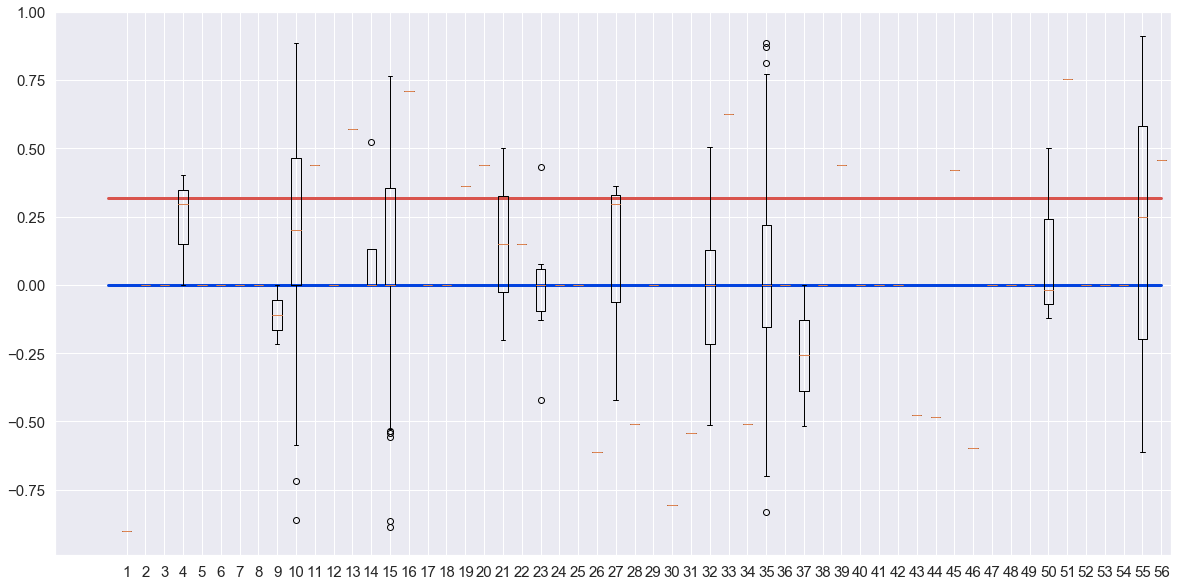

In [79]:
gen_boxplot(dist_sentiment.values(), "dist_sentiment.png")

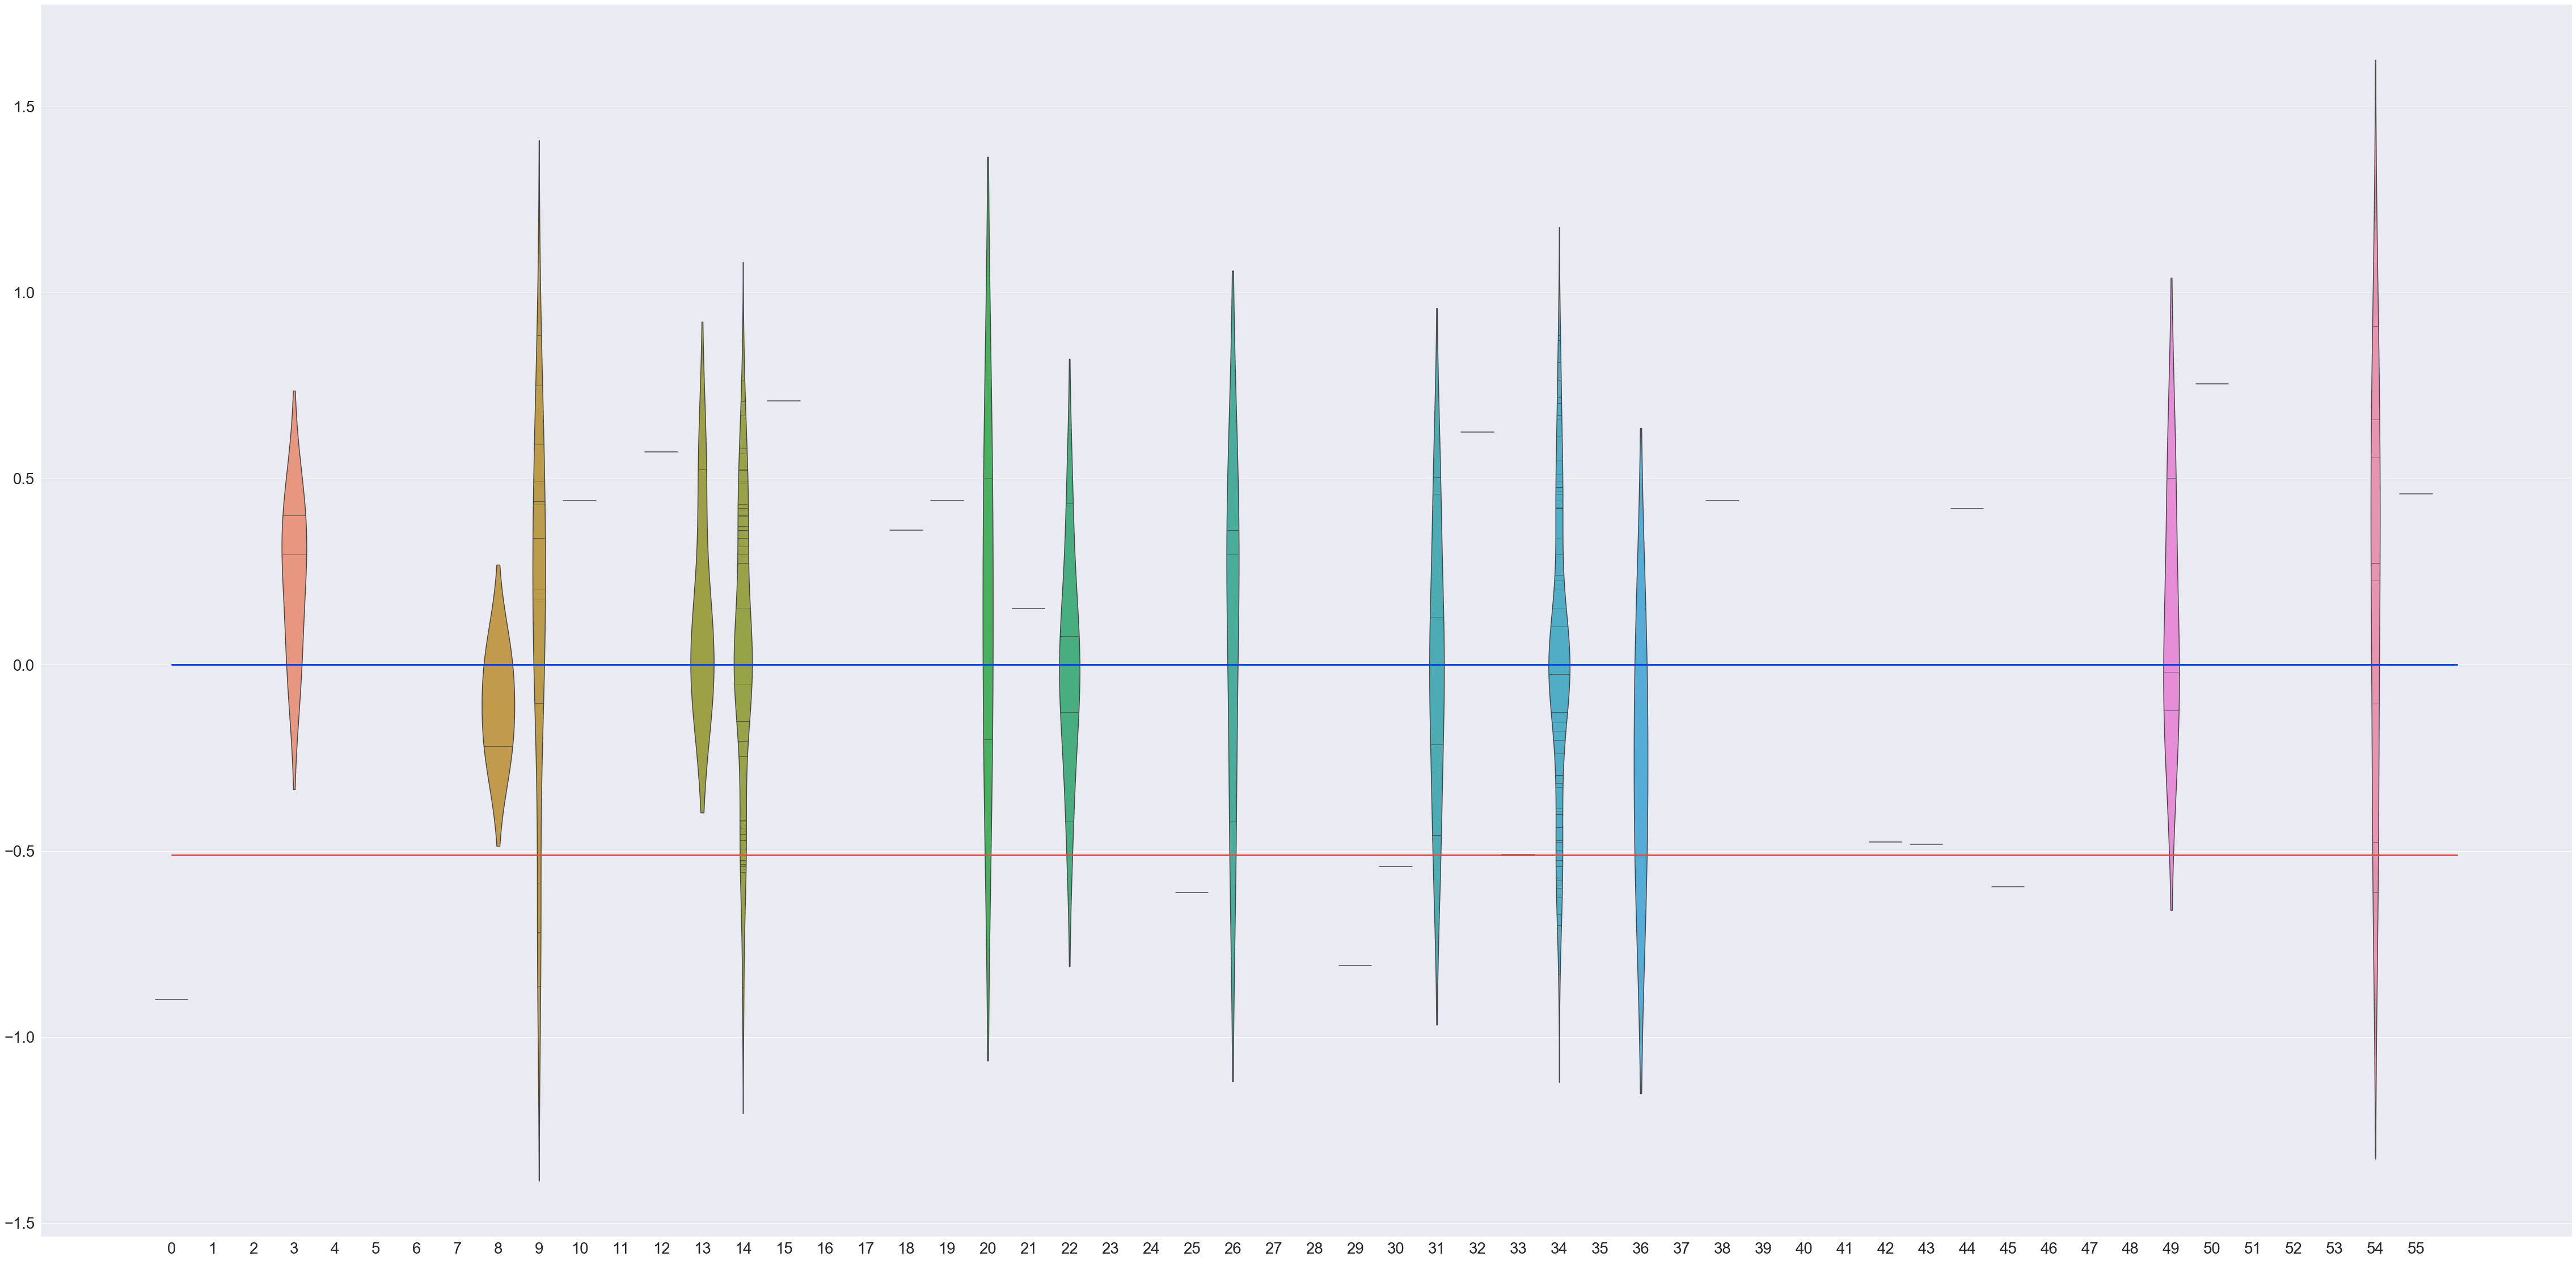

In [80]:
original = "dados//believes\\replies_449836320572321792.json"
gen_violin(dist_sentiment.values(), "dist_sentiment.png", original)

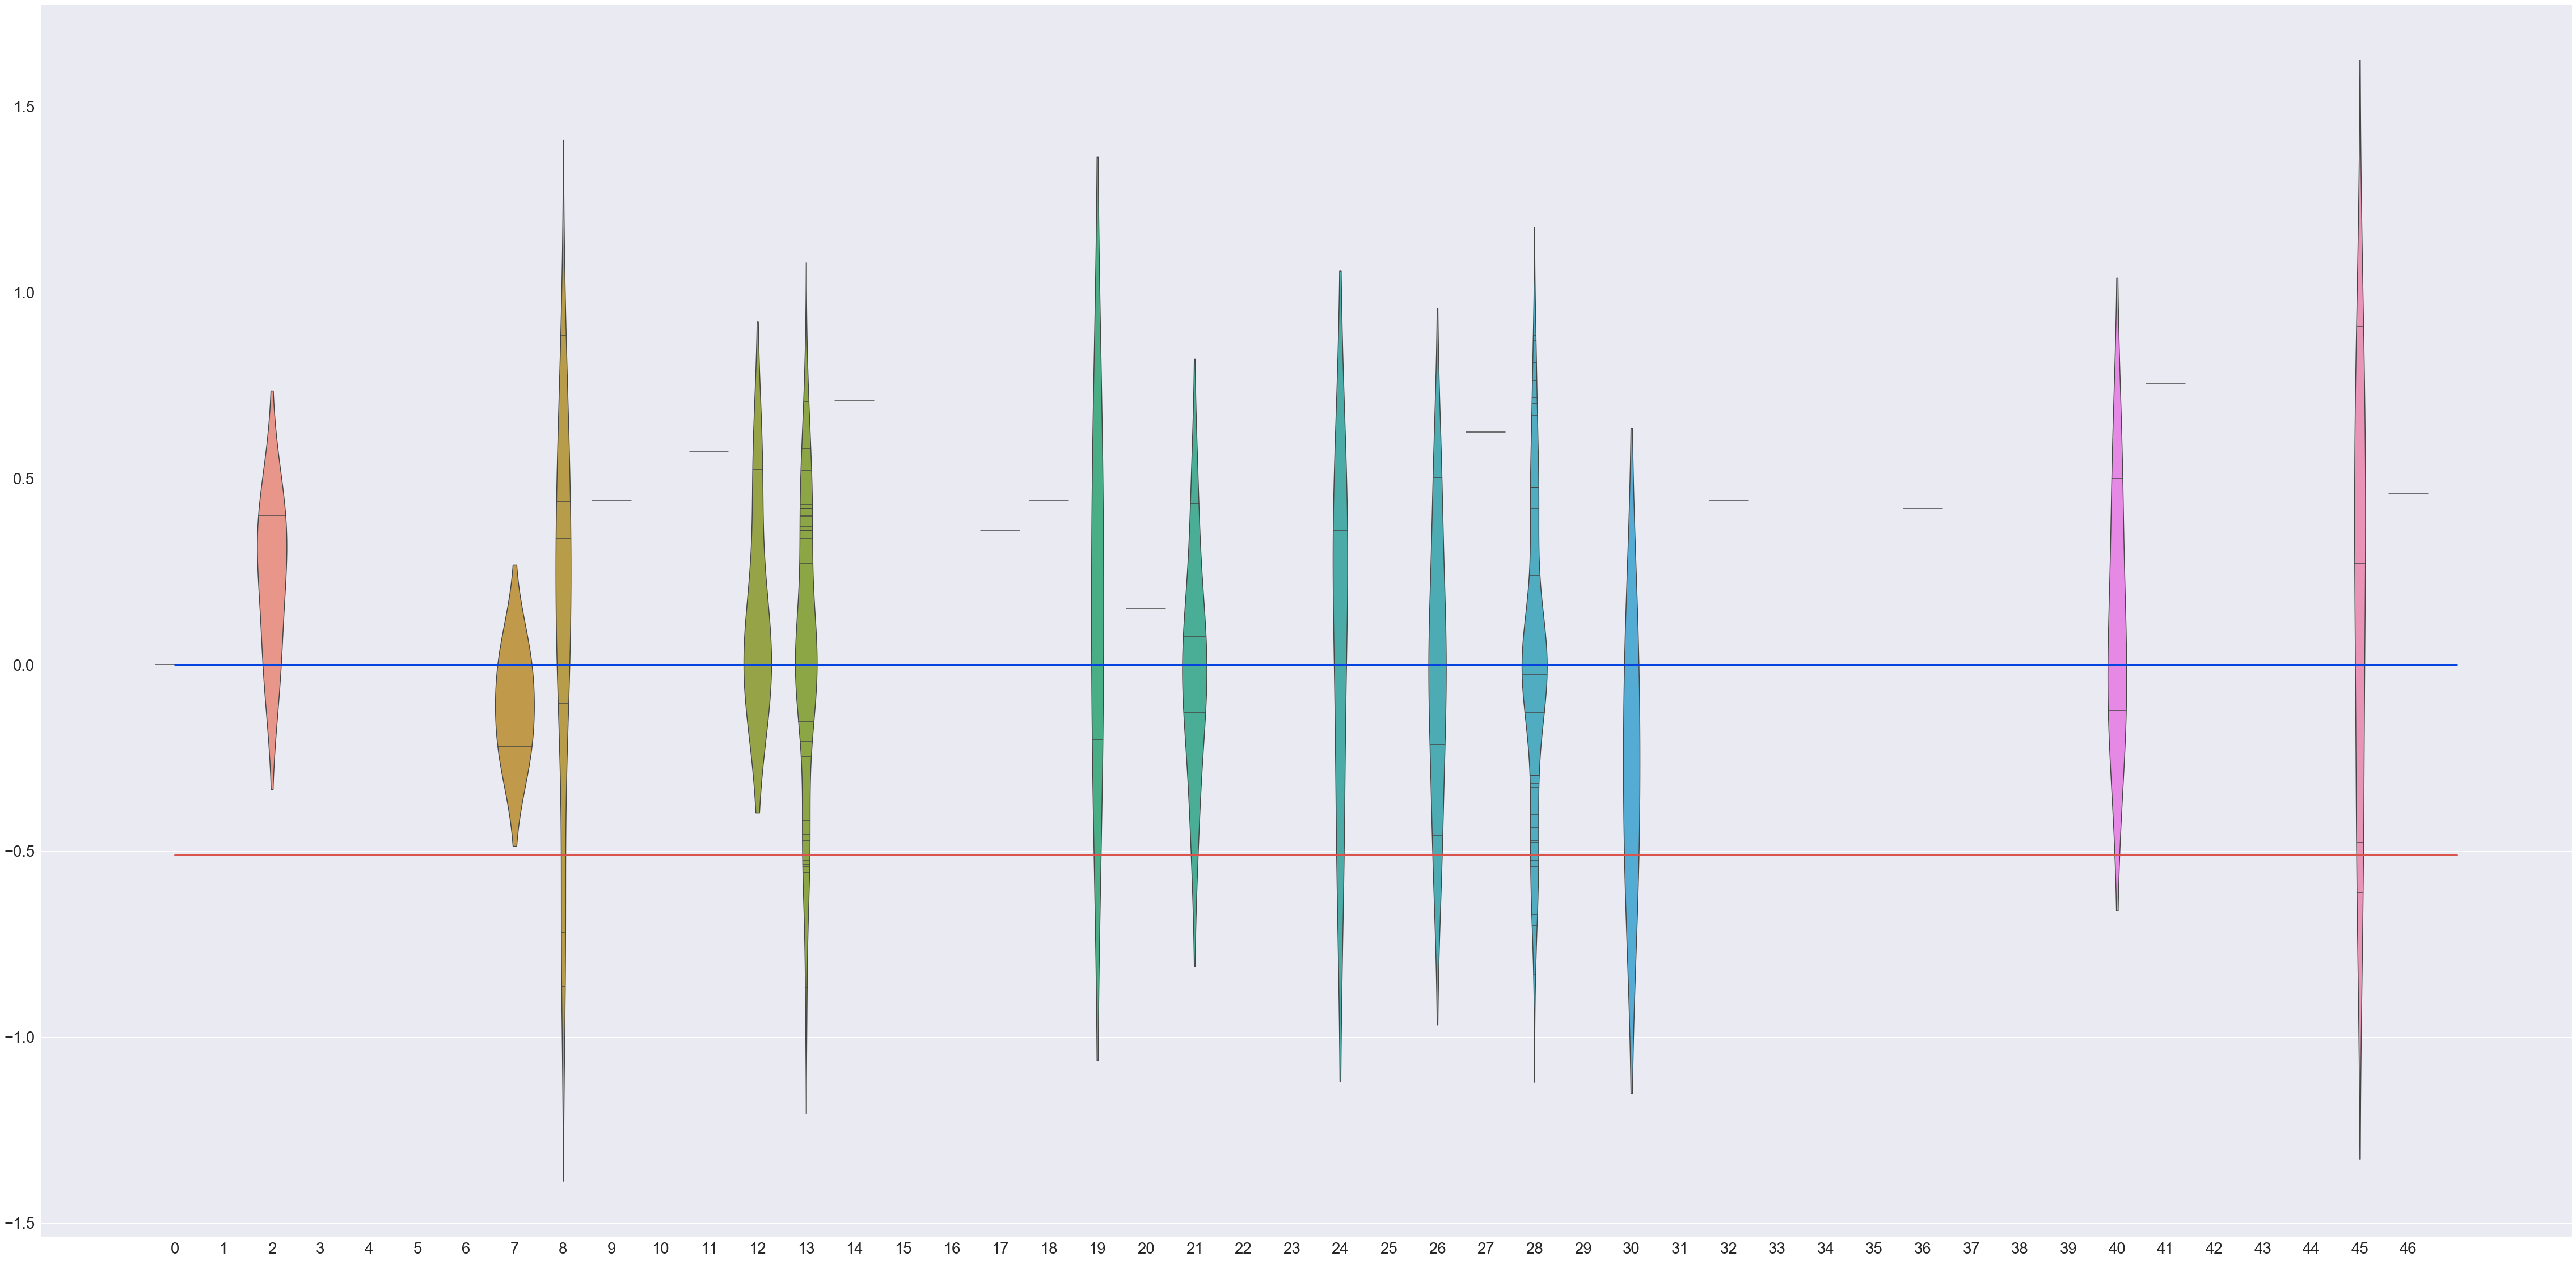

In [81]:
gen_violin(positives.values(), "dist_postives.png", original)

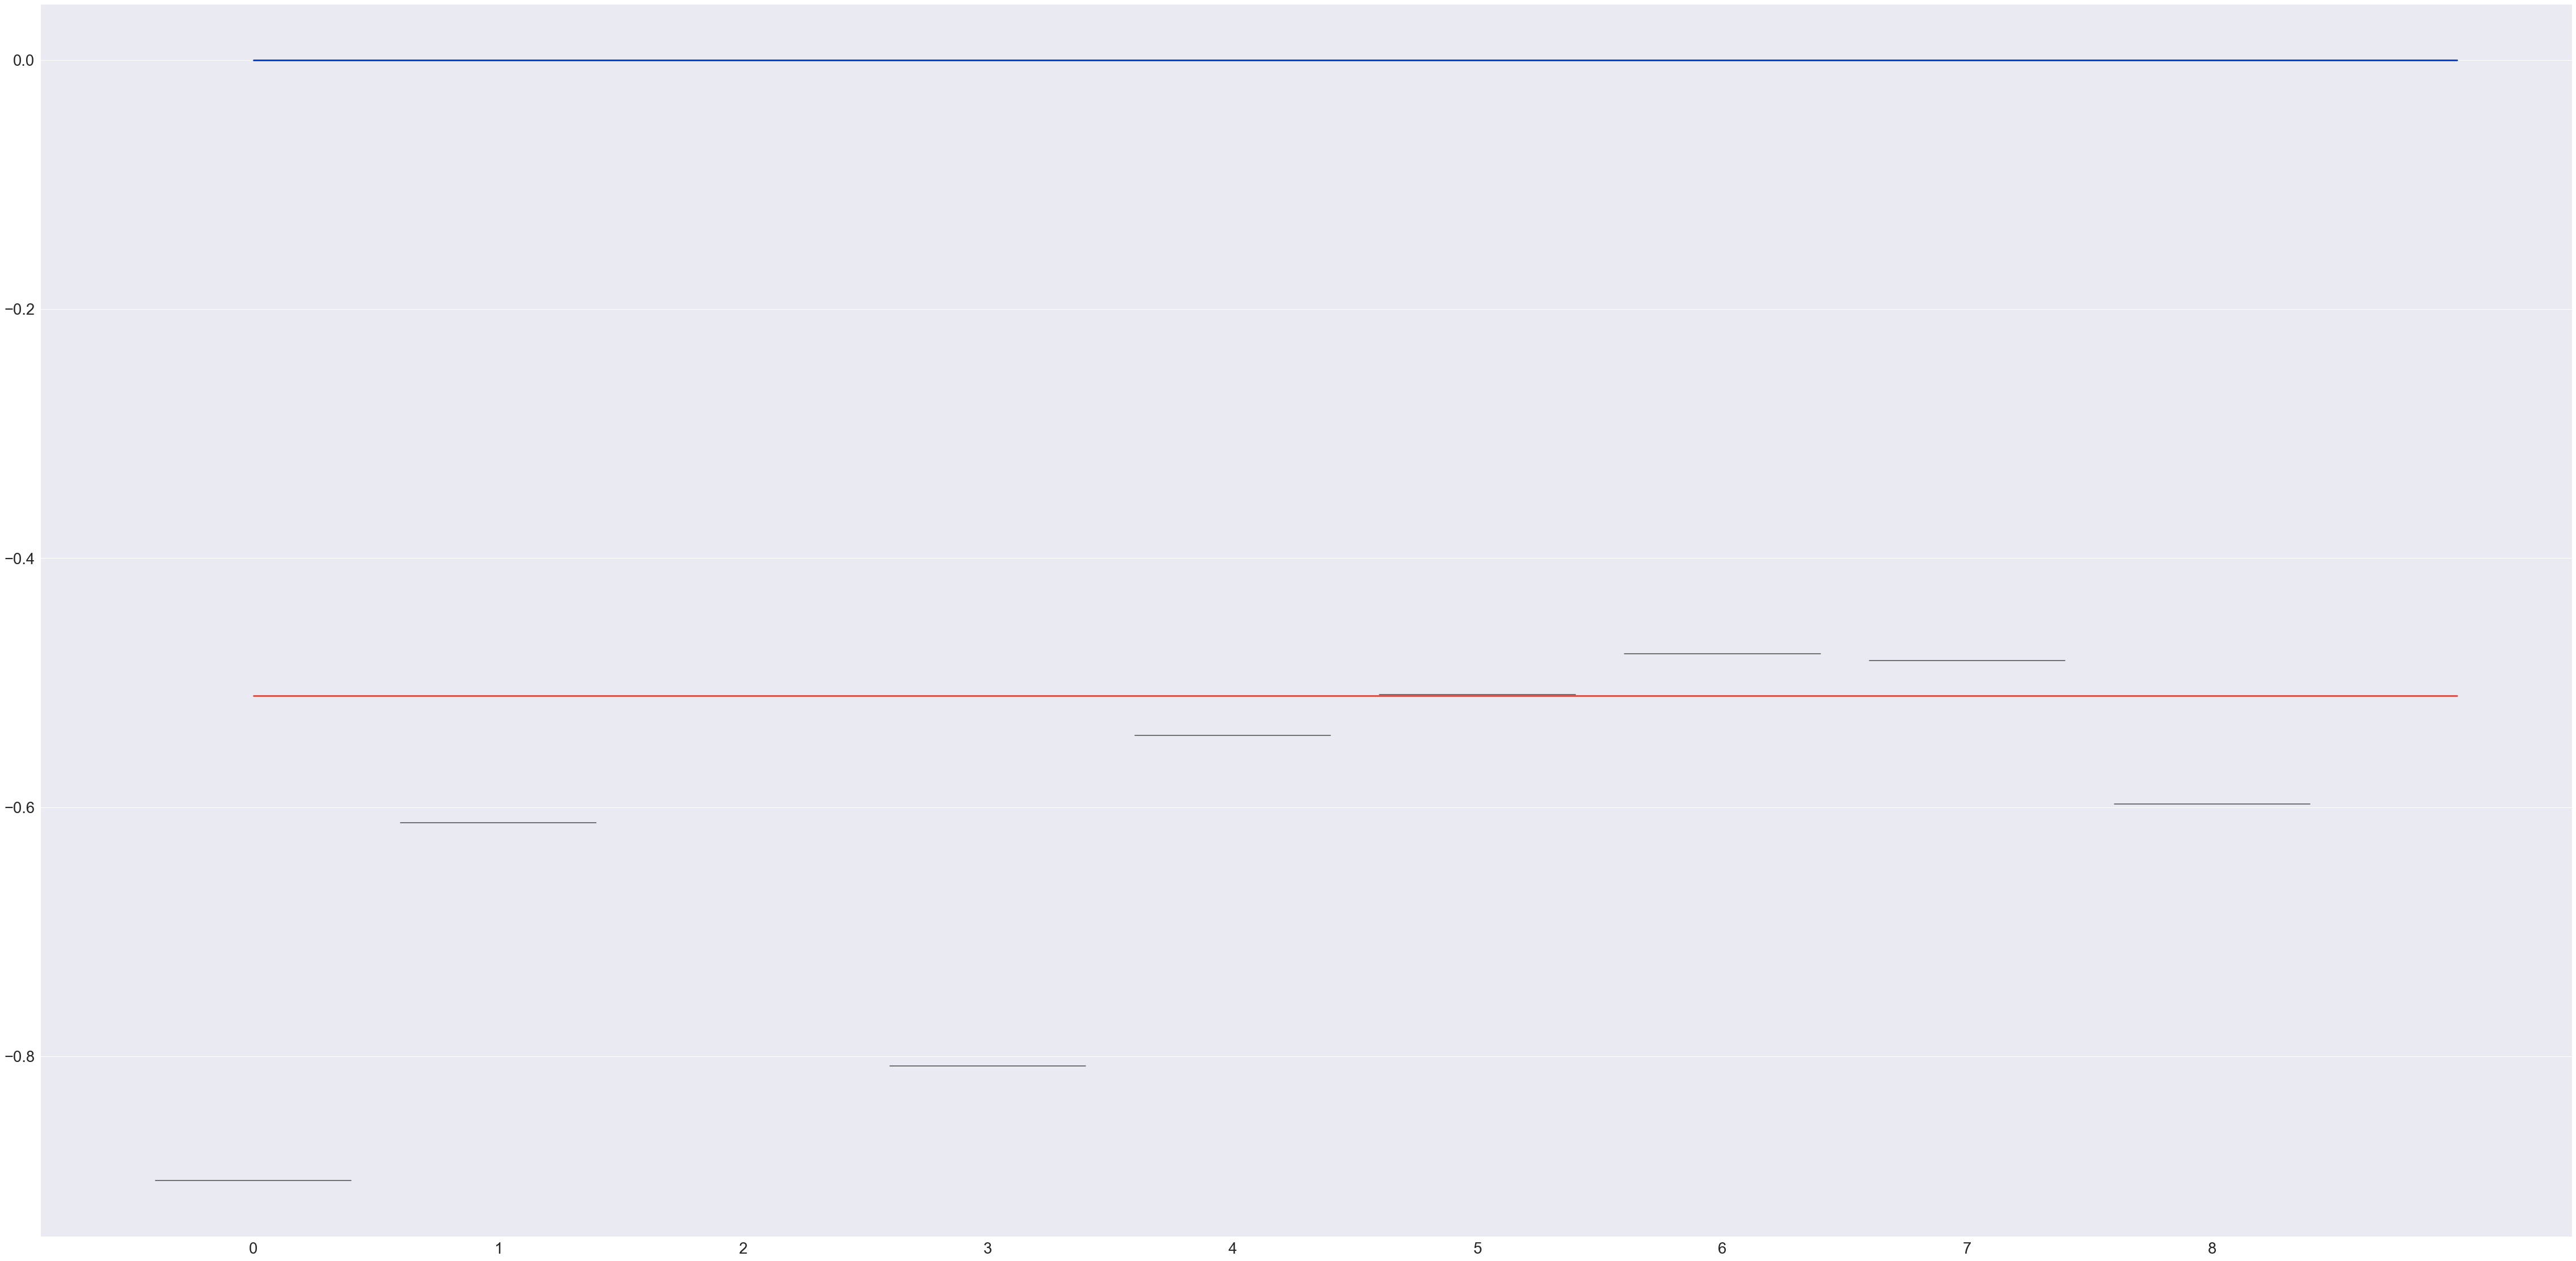

In [82]:
gen_violin(negatives.values(), "dist_negatives.png", original)

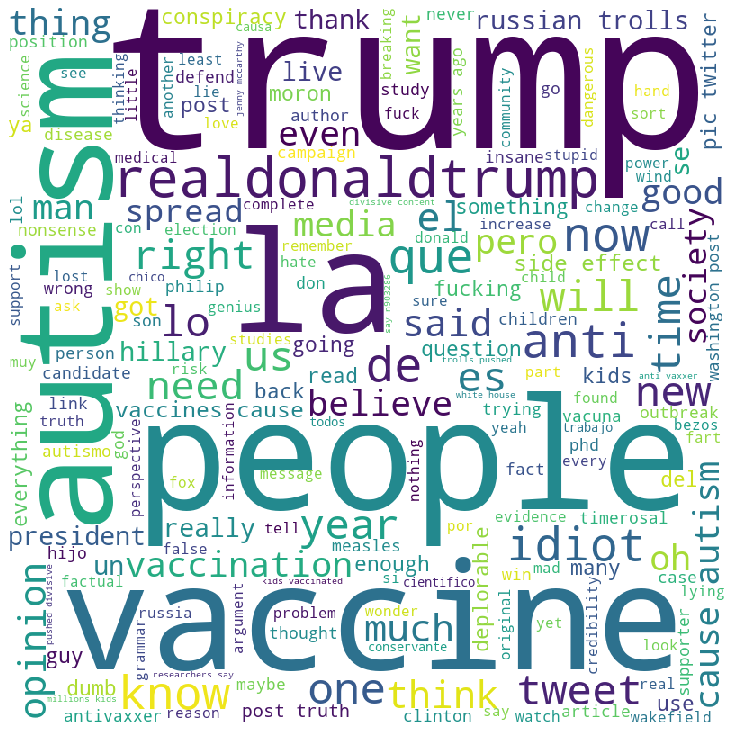

In [109]:
word_cloud(positives, "wordcloud_positives.png")

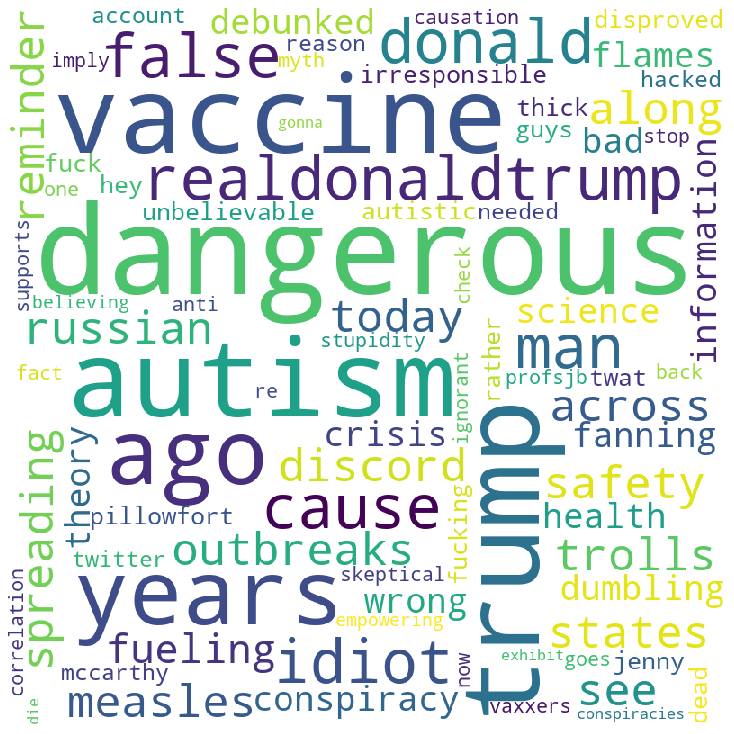

In [110]:
word_cloud(negatives, "wordcloud_negatives.png")